In [52]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from sklearn.metrics import confusion_matrix, roc_curve

### Loading the Dataset

In [3]:
import os
import numpy as np
from PIL import Image
import random

# Path to the directory containing your malaria dataset
dataset_dir = './malaria-dataset'

# List to store training examples as dictionaries
dataset = []

# List of valid image file extensions
valid_extensions = ['.jpg', '.jpeg', '.png']

# Create a mapping of labels to number values
label_to_number = {}
label_counter = 0

# Iterate through each subdirectory (class folder) in the dataset directory
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    
    if os.path.isdir(class_path):
        # Assign a number value to the label and update the mapping
        label_to_number[class_folder] = label_counter
        label_counter += 1
        
        # Iterate through each image file in the class folder
        for image_file in os.listdir(class_path):
            if any(image_file.lower().endswith(ext) for ext in valid_extensions):
                image_path = os.path.join(class_path, image_file)
                
                # Extract class label from folder name
                label = class_folder
                
                # Convert label to number value using the mapping
                label_value = label_to_number[label]
                
                # Load image as a numpy array
                image = np.array(Image.open(image_path))
                
                # Create a dictionary for the training example and add it to the list
                training_example = {'image': image, 'label': label_value}
                dataset.append(training_example)


In [4]:
print(type(dataset[0]))
print(type(dataset))

<class 'dict'>
<class 'list'>


In [5]:
dataset[0]

{'image': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 'label': 0}

In [6]:
# Shuffle the list of training examples
random.shuffle(dataset)

# Split the data into train and test sets
split_ratio = 0.8  # 80% for training, 20% for testing
split_index = int(len(dataset) * split_ratio)
train_set = dataset[:split_index]
test_set = dataset[split_index:]

# Print the number of samples in each set
print("Number of samples in train set:", len(train_set))
print("Number of samples in test set:", len(test_set))

Number of samples in train set: 22046
Number of samples in test set: 5512


### Data Visualization

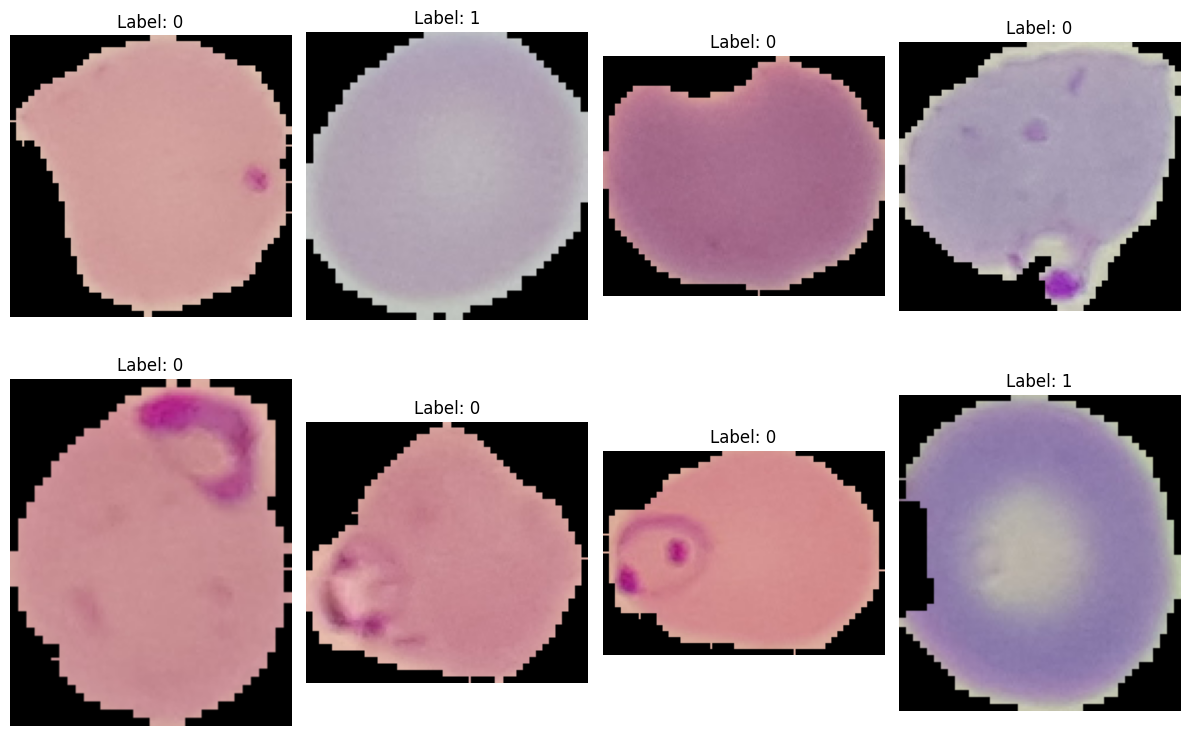

In [7]:
import random
import matplotlib.pyplot as plt

# Assuming you have a list 'train_set' containing your training examples
num_examples_to_plot = 8
selected_examples = random.sample(train_set, num_examples_to_plot)

plt.figure(figsize=(12, 8))
for i, example in enumerate(selected_examples):
    plt.subplot(2, 4, i + 1)
    plt.imshow(example['image'])
    plt.title(f"Label: {example['label']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Rescaling Data

In [8]:
from PIL import Image

# Assuming you have 'train_set' and 'test_set' containing your training and test examples

# Resize and rescale images in the train set
target_size = (64, 64)  # Change to your desired size
with tf.device('CPU'):
    for example in train_set:
        image = Image.fromarray(example['image'])
        image = image.resize(target_size, Image.LANCZOS)
        example['image'] = np.array(image) / 255.0

    # Resize and rescale images in the test set
    for example in test_set:
        image = Image.fromarray(example['image'])
        image = image.resize(target_size, Image.LANCZOS)
        example['image'] = np.array(image) / 255.0


In [9]:

# Choose an index to access an example dictionary
index_to_check = 0  # Change this to the desired index

# Get the image from the chosen dictionary
image = train_set[index_to_check]['image']

# Print the shape of the image
print("Shape of the image:", image.shape)

Shape of the image: (64, 64, 3)


In [10]:
import numpy as np

# Assuming you have 'train_set' and 'test_set' containing your training and test examples

# Prepare training data
train_images = np.array([example['image'] for example in train_set])
train_labels = np.array([example['label'] for example in train_set], dtype=np.int32)

# Prepare test data
test_images = np.array([example['image'] for example in test_set])
test_labels = np.array([example['label'] for example in test_set], dtype=np.int32)

### Data Augementation

In [85]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [86]:
original_image, label = next(iter(train_image),iter())

ValueError: too many values to unpack (expected 2)

### LeNet Model (Sequential API)

In [82]:
dropout_rate= 0.3
model= tf.keras.Sequential([
    InputLayer (input_shape = (64, 64, 3)),
    Conv2D (filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu', kernel_regularizer= L2(0.01)),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides= 2),
    Dropout(rate=dropout_rate),
    
    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu',kernel_regularizer= L2(0.01)),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides= 2),
    Flatten(),
    Dense (1000, activation= "relu",kernel_regularizer= L2(0.01)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),
    Dense (100, activation = "relu",kernel_regularizer= L2(0.01)),
    BatchNormalization(),
    Dense(1, activation = "sigmoid")
])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 6)         168       
                                                                 
 batch_normalization_16 (Bat  (None, 62, 62, 6)        24        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 6)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 6)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 16)        880       
                                                                 
 batch_normalization_17 (Bat  (None, 29, 29, 16)      

### Functional API

In [40]:
# Till now we used Sequential API
# There are 3 ways to build mdoels in tf: Sequential API, Functional API and Model Subclassing
# Multi input Multi output models are not possible with Sequential API. It allows making more complex models
# func_input=Input(shape=(64,64,3), name="Input Image")
# x=Conv2D (filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input) ### Feature Extraction Layers
# x=BatchNormalization()(x)
# x=MaxPool2D (pool_size=2, strides= 2)(x)
# x=Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
# x=BatchNormalization()(x)
# x=MaxPool2D (pool_size=2, strides= 2)(x)

# x=Flatten()(x)                                       ### Classification Layers
# x=Dense (1000, activation= "relu")(x)
# x=BatchNormalization()(x)
# x=Dense (100, activation = "relu")(x)
# x=BatchNormalization()(x)
# func_output=Dense(1, activation = "sigmoid")(x)
# seq_model=Model(func_input,func_output, name= "Functional_Model")
# seq_model.summary()

Model: "Functional_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 62, 62, 6)         168       
                                                                 
 batch_normalization_28 (Bat  (None, 62, 62, 6)        24        
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 31, 31, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 29, 29, 16)        880       
                                                                 
 batch_normalization_29 (Bat  (None, 29, 29, 16)  

### Above Model can also be divided into 2 Models

In [43]:
# ### First we make feature Extractor Model
# func_input=Input(shape=(64,64,3), name="Input Image")
# x=Conv2D (filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input) ### Feature Extraction Layers
# x=BatchNormalization()(x)
# x=MaxPool2D (pool_size=2, strides= 2)(x)
# x=Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
# x=BatchNormalization()(x)
# output=MaxPool2D (pool_size=2, strides= 2)(x)
# feature_extractor_model=Model(func_input,output, name= "Feature_Extractor")
# feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 Input Image (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 62, 62, 6)         168       
                                                                 
 batch_normalization_36 (Bat  (None, 62, 62, 6)        24        
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 31, 31, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 29, 29, 16)        880       
                                                                 
 batch_normalization_37 (Bat  (None, 29, 29, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooli

In [44]:
# ### Classification Model
# func_input=Input(shape=(64,64,3), name="Input Image")
# x=feature_extractor_model(func_input)
# x=Flatten()(x)                                       ### Classification Layers
# x=Dense (1000, activation= "relu")(x)
# x=BatchNormalization()(x)
# x=Dense (100, activation = "relu")(x)
# x=BatchNormalization()(x)
# func_output=Dense(1, activation = "sigmoid")(x)
# divided_seq_model=Model(func_input,func_output, name= "Lenet_Model")
# divided_seq_model.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 Feature_Extractor (Function  (None, 14, 14, 16)       1136      
 al)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 3136)              0         
                                                                 
 dense_27 (Dense)            (None, 1000)              3137000   
                                                                 
 batch_normalization_38 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dense_28 (Dense)            (None, 100)               

### Model Subclassing

In [64]:
### Yet another way to define a model
### First we define a feature exractor then we classify
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [57]:
### Classification Model
func_input = Input(shape=(64,64,3), name="Input Image")
x=feature_sub_classed(func_input)
x=Flatten()(x)                                       ### Classification Layers
x=Dense (1000, activation= "relu")(x)
x=BatchNormalization()(x)
x=Dense (100, activation = "relu")(x)
x=BatchNormalization()(x)
func_output=Dense(1, activation = "sigmoid")(x)
subclassed_model=Model(func_input,func_output, name= "Feature_Subclassed_Model")
subclassed_model.summary()

Model: "Feature_Subclassed_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 feature_extractor_3 (Featur  (None, 14, 14, 16)       1488      
 eExtractor)                                                     
                                                                 
 flatten_13 (Flatten)        (None, 3136)              0         
                                                                 
 dense_39 (Dense)            (None, 1000)              3137000   
                                                                 
 batch_normalization_54 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dense_40 (Dense)            (None, 100)  

In [65]:
### Instead of above we can also do the following which is completely subclassed
### The above was a mix of Subclassing and Fucntional API
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")
    
  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x
    
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,64,64,3]))
lenet_sub_classed.summary()

Model: "lenet_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_8 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_16 (Flatten)        multiple                  0         
                                                                 
 dense_48 (Dense)            multiple                  313700    
                                                                 
 batch_normalization_70 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_49 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_71 (Bat  multiple               

### Making Custom Layers (See Image)
<!-- 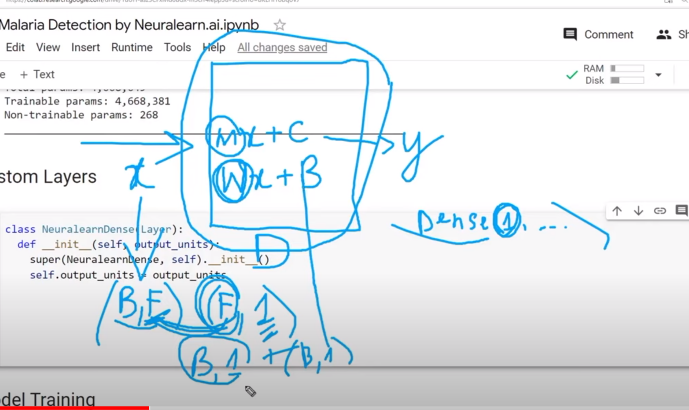 -->

In [11]:
class CustomDense(Layer):
  def __init__(self, output_units, activation):
    super(CustomDense, self).__init__()
    self.output_units = output_units
    self.activation = activation
  
  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)
  
  def call(self, input_features):

    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)

    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output

### Sequential API using Custom Layer

In [12]:
# func_input=Input(shape=(64,64,3), name="Input Image")
# x=Conv2D (filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input) ### Feature Extraction Layers
# x=BatchNormalization()(x)
# x=MaxPool2D (pool_size=2, strides= 2)(x)
# x=Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
# x=BatchNormalization()(x)
# x=MaxPool2D (pool_size=2, strides= 2)(x)

# x=Flatten()(x)                                       ### Classification Layers
# x=CustomDense(1000, activation= "relu")(x)
# x=BatchNormalization()(x)
# x=CustomDense(100, activation = "relu")(x)
# x=BatchNormalization()(x)
# func_output=CustomDense(1, activation = "sigmoid")(x)
# seq_model=Model(func_input,func_output, name= "Functional_Model")
# seq_model.summary()
lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (64, 64, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Flatten(),
                             
                             CustomDense(100, activation = "relu"),
                             BatchNormalization(),
                             
                             CustomDense(10, activation = "relu"),
                             BatchNormalization(),

                             CustomDense(1, activation = "sigmoid"),

])
lenet_custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 6)         168       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        880       
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 16)       64        
 hNormalization)                                                 
                                                        

### Generating Custom Callbacks

In [13]:
### Callbacks serve different purposes while training our model to improve its performance etc. 
### Some examples can be LearningRateScheduler, History etc.    
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))
    
  # def on_batch_end(self, batch, logs):
  #   print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

### CSV Logger(Predefined CallBacks)

In [14]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

### Early Stopping Callback

In [15]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

### Learning Rate Scheduling

In [16]:
def scheduler(epoch, lr):

  if epoch <= 1:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
    
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

### Model Checkpointing Callback

In [62]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints',
    monitor ="val_loss",
    verbose = 1,
    save_best_only = False,
    save_weights_only = True,
    mode = "auto",
    save_freq="epoch",
)


### Reduced LR on Plateau

In [66]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=2, verbose=1
)

### Compiling and Training Model

In [83]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
# model.compile(optimizer = Adam(learning_rate=0.01) ,loss=BinaryCrossentropy(), metrics=['accuracy'])
model.compile(optimizer = Adam(learning_rate=0.01) ,loss=BinaryCrossentropy(), metrics=metrics)


In [84]:
with tf.device('CPU'):
    # history=model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs = 5, verbose = 1)
    history=model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs = 5, verbose = 1, callbacks= [])

Epoch 1/5
689/689 [==============================] - 77s 110ms/step - loss: 3.3799 - tp: 8715.0000 - fp: 2667.0000 - tn: 8328.0000 - fn: 2336.0000 - accuracy: 0.7731 - precision: 0.7657 - recall: 0.7886 - auc: 0.8469 - val_loss: 4.3929 - val_tp: 2713.0000 - val_fp: 2260.0000 - val_tn: 524.0000 - val_fn: 15.0000 - val_accuracy: 0.5873 - val_precision: 0.5455 - val_recall: 0.9945 - val_auc: 0.8793
Epoch 2/5
689/689 [==============================] - 77s 112ms/step - loss: 2.2323 - tp: 10454.0000 - fp: 1471.0000 - tn: 9524.0000 - fn: 597.0000 - accuracy: 0.9062 - precision: 0.8766 - recall: 0.9460 - auc: 0.9352 - val_loss: 2.2391 - val_tp: 0.0000e+00 - val_fp: 4.0000 - val_tn: 2780.0000 - val_fn: 2728.0000 - val_accuracy: 0.5044 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9449
Epoch 3/5
689/689 [==============================] - 74s 107ms/step - loss: 2.0698 - tp: 10503.0000 - fp: 1197.0000 - tn: 9798.0000 - fn: 548.0000 - accuracy: 0.9208 - precision: 0.8977 - recal

In [49]:
train_labels.shape

(22046,)

### Results Demonstration

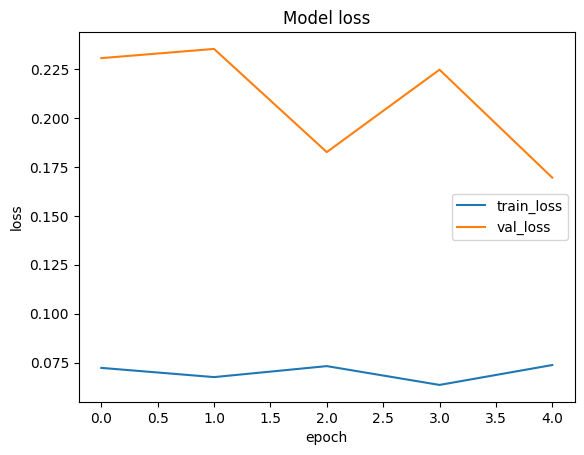

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

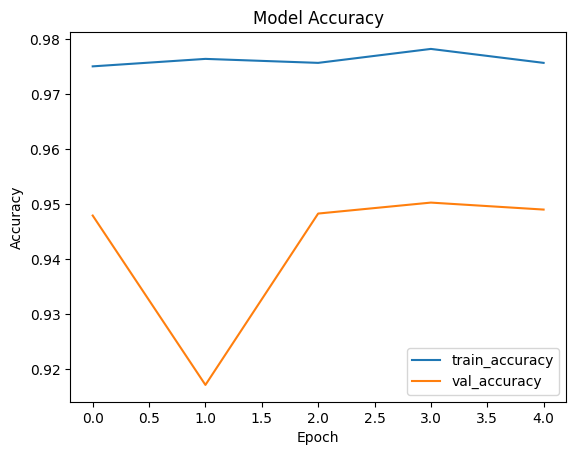

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Evaluating the model

In [43]:
# Assuming you have 'test_set' containing your test examples

# Prepare test data
test_images = np.array([example['image'] for example in test_set])
test_labels = np.array([example['label'] for example in test_set])

# # Normalize pixel values to be in the range [0, 1]
# test_images = test_images / 255.0


In [48]:

# # Evaluate the model when using only accuracy and loss

# test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# # Print the test loss and accuracy
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)

#### Evaluating with multiple metrics
def evaluate_with_metrics(model, test_images, test_labels, metrics):
    results = model.evaluate(test_images, test_labels, verbose=0)
    metric_names = model.metrics_names
    
    for name, result in zip(metric_names, results):
        print(f"{name}: {result:.4f}")

# Assuming you have 'test_set' containing your test examples



# Specify the metrics you want to evaluate
metrics = [TruePositives(), FalsePositives(), TrueNegatives(), FalseNegatives(), BinaryAccuracy(), Precision(), Recall(), AUC()]

# Evaluate the model with specified metrics and print the results
evaluate_with_metrics(lenet_custom_model, test_images, test_labels, metrics)


loss: 0.1434
tp: 2682.0000
fp: 122.0000
tn: 2597.0000
fn: 111.0000
accuracy: 0.9577
precision: 0.9565
recall: 0.9603
auc: 0.9880


### Confusion Matrix

In [50]:
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = []
inp = []
for x, y in zip(test_images, test_labels):
    labels.append(y)
    inp.append(x)

In [52]:
print(np.array(inp).shape)

(5512, 64, 64, 3)


In [61]:
labels = np.array(labels)
print(labels)
print(labels.shape)

[1 0 1 ... 0 0 1]
(5512,)


In [59]:
predicted = lenet_custom_model.predict(np.array(inp))
print(predicted[:,0])

173/173 [==============================] - 1s 2ms/step
[0.9366115  0.03433868 0.9617613  ... 0.00447212 0.0099768  0.98153716]


In [62]:
predicted[:,0].shape

(5512,)

[[2597  122]
 [ 111 2682]]


Text(0.5, 58.7222222222222, 'Predicted')

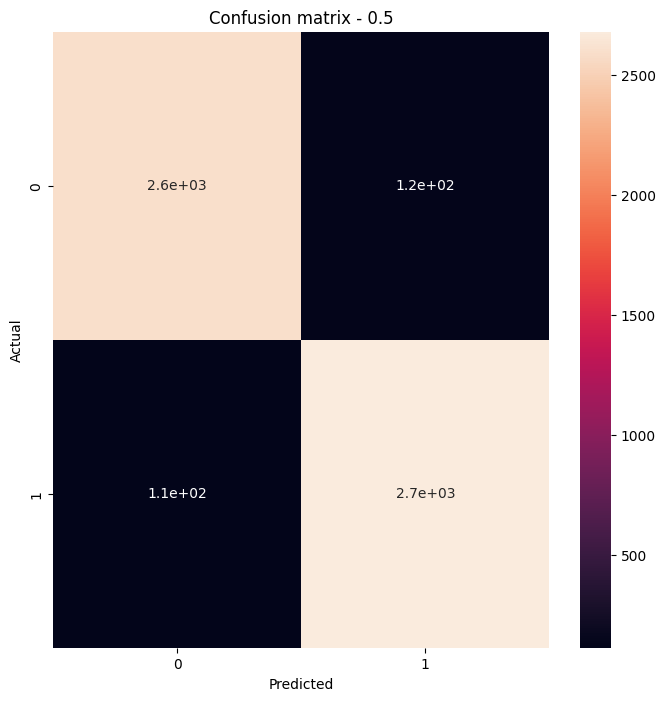

In [78]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Plotting ROC Curves

374 374 374


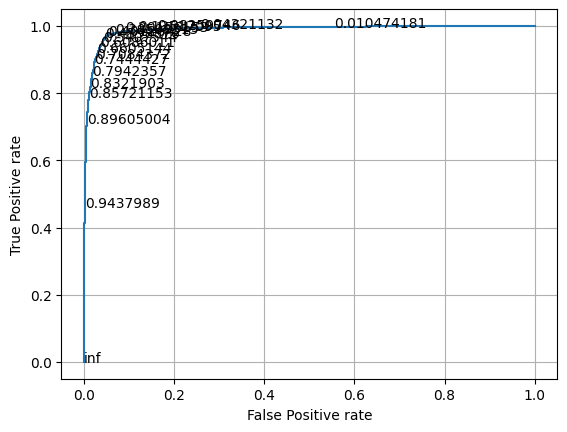

In [82]:
fp, tp, thresholds = roc_curve(labels, predicted)
print(len(fp),len(tp),len(thresholds))
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
plt.show()
### Pick one of the threshold value depending on your requirement that either you require a high false positive rate or false negative

### Prediction on test examples

In [17]:
import numpy as np

# Assuming you have 'train_set' containing your training examples
# Assuming you have 'model' defined

index_to_check = 1  # Change this to the desired index
# Get the image from the chosen dictionary
image = train_set[index_to_check]['image']

# Expand dimensions to create a batch with a single image
image_batch = np.expand_dims(image, axis=0)

# Predict using the model
predictions = model.predict(image_batch)
print(predictions)
# # 'predictions' will contain the predicted probabilities for each class for the single image
# predicted_class = np.argmax(predictions, axis=1)

# print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 171ms/step
[[0.9482492]]


1/1 [==============================] - 0s 17ms/step


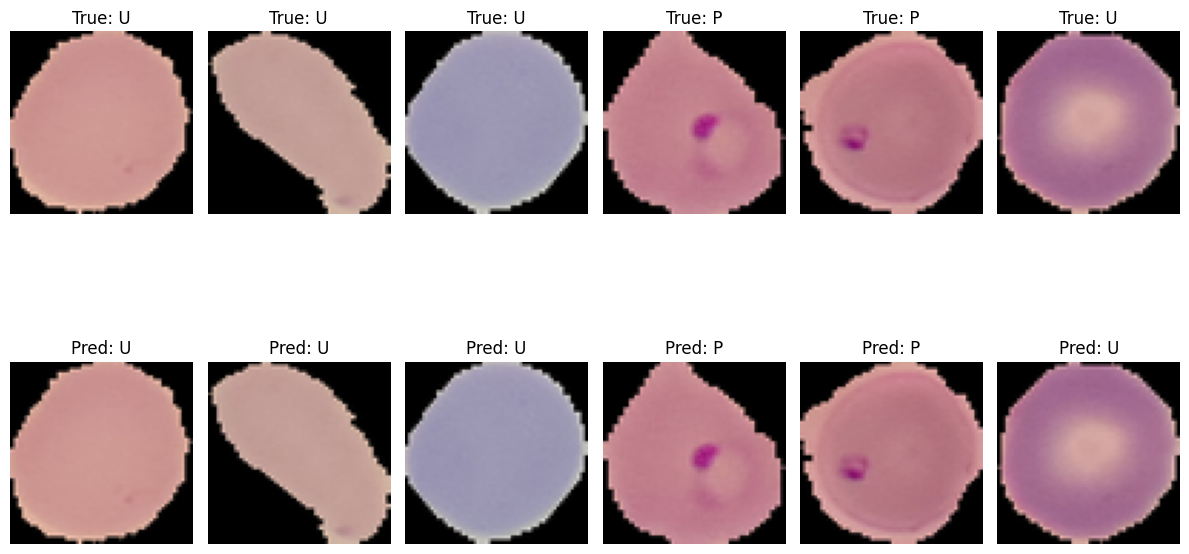

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Your parasite_or_not function
def parasite_or_not(x):
    if x < 0.5:
        return 'P'
    else:
        return 'U'

# Assuming you have 'train_set' and 'model' defined
num_examples_to_plot = 6  # Change the number of examples to plot

plt.figure(figsize=(12, 8))
for i, example in enumerate(train_set[:num_examples_to_plot]):
    image = example['image']
    label = example['label']
    
    # Expand dimensions to create a batch with a single image
    image_batch = np.expand_dims(image, axis=0)

    # Predict using the model
    predictions = model.predict(image_batch)
    # predictions = loaded_model.predict(image_batch)  # For loaded model prediction
    predicted_class = np.argmax(predictions, axis=1)
    
    # Apply your function to the label and prediction
    true_result = parasite_or_not(label)
    predicted_result = parasite_or_not(predictions[0][predicted_class[0]])
    
    plt.subplot(2, num_examples_to_plot, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_result}")
    plt.axis('off')

    plt.subplot(2, num_examples_to_plot, num_examples_to_plot + i + 1)
    plt.imshow(image)
    plt.title(f"Pred: {predicted_result}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Saving the Model (Both Weights & Config)

In [19]:
# Model Configuration is its architecture 
# While Model Weights give us outputs after multiplying with input
model.save("SavedLenetModel")

INFO:tensorflow:Assets written to: SavedLenetModel\assets


INFO:tensorflow:Assets written to: SavedLenetModel\assets


### Loading a Model

In [20]:
loaded_model= tf.keras.models.load_model("SavedLenetModel")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 6)         168       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        880       
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 16)       64        
 hNormalization)                                                 
                                                        

In [21]:
### Saving Model as hdf5 (It is a lightweight saved model file)
### Do not use it when working with hdf5 because it does not save them
model.save("SavedLenetModel.hdf5")

In [22]:
loaded_model= tf.keras.models.load_model("SavedLenetModel.hdf5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 6)         168       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        880       
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 16)       64        
 hNormalization)                                                 
                                                        

### Saving only model weights

In [23]:
model.save_weights("weights/model_weights")

In [24]:
### Loading Weights
### Reinitialze the Model before doing this
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

173/173 [==============================] - 1s 4ms/step - loss: 0.1497 - accuracy: 0.9575
Test Loss: 0.1496712863445282
Test Accuracy: 0.9575471878051758


In [25]:
### If now I recompile the model, the weights will be randomly initialized. And the atest accuracy will fall
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

173/173 [==============================] - 1s 3ms/step - loss: 0.1497 - accuracy: 0.9575
Test Loss: 0.1496712863445282
Test Accuracy: 0.9575471878051758


In [26]:
### You can see the accuracy dropped. You can now load the previous weights
model.load_weights("weights/model_weights")

In [27]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

173/173 [==============================] - 1s 3ms/step - loss: 0.1497 - accuracy: 0.9575
Test Loss: 0.1496712863445282
Test Accuracy: 0.9575471878051758
